Projet Machine Learning 


In [2]:
# librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier


1. data cleaning & EDA

In [3]:
# importing data
df=pd.read_csv("insurance_claims.csv")
#df.info()
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,415,52,794731,22-02-15,IN,250/500,1000,973.50,0,468634,...,YES,51090,7860,7860,35370,Toyota,Highlander,2003,N,NaN
1,89,32,266247,17-01-15,IN,100/300,2000,1482.53,0,620358,...,?,100,10,20,70,Audi,A3,2002,N,NaN
2,180,36,420948,03-01-15,IL,100/300,500,1272.46,0,456959,...,?,69630,12660,6330,50640,Toyota,Corolla,1998,N,NaN
3,160,37,921202,28-12-14,OH,500/1000,500,1374.22,0,472135,...,NO,72930,6630,13260,53040,Accura,TL,2015,N,NaN
4,256,43,883980,13-12-14,OH,100/300,500,1203.17,0,455810,...,?,63250,11500,5750,46000,Nissan,Ultima,1997,N,NaN


In [4]:
# processing data
df.replace('?', np.nan, inplace = True)
df.describe().transpose()

# missing values
df.isna().sum() / len(df) * 100
df = df.drop(columns='_c39') # _c39 column useless because empty, we can drop it. 
df.drop_duplicates(inplace=True)

# handling missing values
df['collision_type'] = df['collision_type'].fillna(df['collision_type'].mode()[0])
df['authorities_contacted'] = df['authorities_contacted'].fillna('None')
df['property_damage'] = df['property_damage'].fillna(df['property_damage'].mode()[0])
df['police_report_available'] = df['police_report_available'].fillna(df['police_report_available'].mode()[0])

# no more missing values :)

In [5]:
# let's check the unique values for each variable

print(df.nunique())
# we can drop var that have too many distinct values and are not relevant in our study: policy_number, insured_zip, incident_location (we have city
# and state already), insured_hobbies (no relevance here), auto_model (too many values, maker should be enough)

df=df.drop(columns='policy_number')
df=df.drop(columns='insured_zip')
df=df.drop(columns='incident_location')
df=df.drop(columns='insured_hobbies')
df=df.drop(columns='auto_model')

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductable                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital-gains                   338
capital-loss                    354
incident_date                    60
incident_type                     4
collision_type                    3
incident_severity                 4
authorities_contacted             5
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

In [6]:
data_types = df.dtypes
print(data_types)

months_as_customer               int64
age                              int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                 object
bodily_injuries                  int64
witnesses                

In [7]:
# info on numerical variables
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,2.039540e+02,1.151132e+02,0.00,115.7500,199.5,276.250,479.00
age,1000.0,3.894800e+01,9.140287e+00,19.00,32.0000,38.0,44.000,64.00
policy_deductable,1000.0,1.136000e+03,6.118647e+02,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1.256406e+03,2.441674e+02,433.33,1089.6075,1257.2,1415.695,2047.59
umbrella_limit,1000.0,1.101000e+06,2.297407e+06,-1000000.00,0.0000,0.0,0.000,10000000.00
capital-gains,1000.0,2.512610e+04,2.787219e+04,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-2.679370e+04,2.810410e+04,-111100.00,-51500.0000,-23250.0,0.000,0.00
incident_hour_of_the_day,1000.0,1.164400e+01,6.951373e+00,0.00,6.0000,12.0,17.000,23.00
number_of_vehicles_involved,1000.0,1.839000e+00,1.018880e+00,1.00,1.0000,1.0,3.000,4.00
bodily_injuries,1000.0,9.920000e-01,8.201272e-01,0.00,0.0000,1.0,2.000,2.00


In [8]:
# categorical columns

categorical_col = df.select_dtypes(include = ['object'])
print(categorical_col.head())

# instead of incident_date, let's take the number of days from the policy_bind_date until the incident_date:
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'], format='%d-%m-%y')
df['incident_date'] = pd.to_datetime(df['incident_date'], format='%y-%m-%d')
df['days_difference_bind_incident'] = (df['incident_date'] - df['policy_bind_date']).dt.days

df=df.drop(columns='policy_bind_date')

  policy_bind_date policy_state policy_csl insured_sex  \
0         22-02-15           IN    250/500        MALE   
1         17-01-15           IN    100/300      FEMALE   
2         03-01-15           IL    100/300        MALE   
3         28-12-14           OH   500/1000      FEMALE   
4         13-12-14           OH    100/300      FEMALE   

  insured_education_level insured_occupation insured_relationship  \
0                     PhD  machine-op-inspct        not-in-family   
1                      MD       tech-support        not-in-family   
2                 College     prof-specialty                 wife   
3                      MD       craft-repair       other-relative   
4                      MD     prof-specialty            unmarried   

  incident_date             incident_type   collision_type incident_severity  \
0      02-02-15   Multi-vehicle Collision   Rear Collision        Total Loss   
1      23-01-15                Parked Car   Rear Collision    Trivial Damage

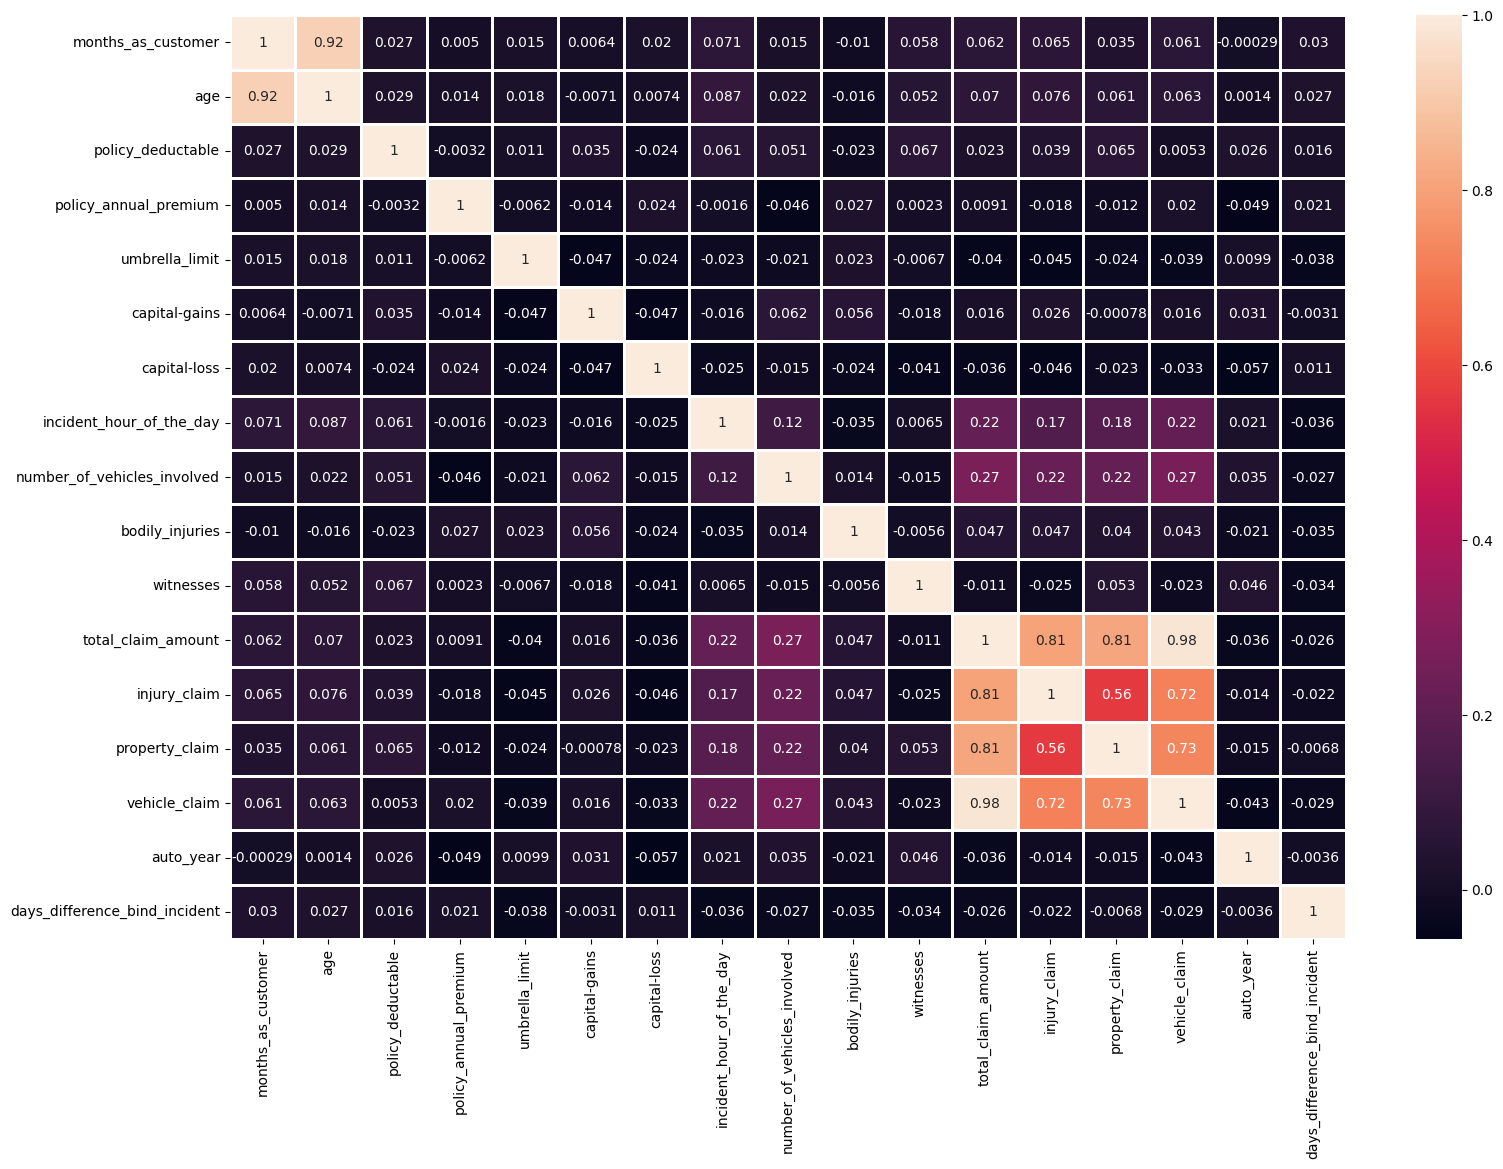

In [9]:
# correlation matrix
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr()
plt.figure(figsize = (18, 12))
sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

# we get rid of age, we keep months_as_customer since high colinearity (>0.9)
df=df.drop(columns='age')

# we also get rid of total_claim_amount since it's the total amount of injury_claim, property_claim and vehicle_claim.
# high colinearity (>0.8)
df=df.drop(columns='total_claim_amount')

In [10]:
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})
df.head()

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_relationship,...,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported,days_difference_bind_incident
0,415,IN,250/500,1000,973.50,0,MALE,PhD,machine-op-inspct,not-in-family,...,1,3,YES,7860,7860,35370,Toyota,2003,0,-4755
1,89,IN,100/300,2000,1482.53,0,FEMALE,MD,tech-support,not-in-family,...,1,2,NO,10,20,70,Audi,2002,0,2920
2,180,IL,100/300,500,1272.46,0,MALE,College,prof-specialty,wife,...,2,1,NO,12660,6330,50640,Toyota,1998,0,1504
3,160,OH,500/1000,500,1374.22,0,FEMALE,MD,craft-repair,other-relative,...,1,0,NO,6630,13260,53040,Accura,2015,0,1479
4,256,OH,100/300,500,1203.17,0,FEMALE,MD,prof-specialty,unmarried,...,0,0,NO,11500,5750,46000,Nissan,1997,0,-3223


In [11]:
# correlation with target variable (fraud_reported)
numeric_df = df.select_dtypes(include=['number'])
correlation_with_target = numeric_df.corr(method='spearman')['fraud_reported'].sort_values(ascending=False)

print(correlation_with_target)

fraud_reported                   1.000000
vehicle_claim                    0.143318
property_claim                   0.133503
injury_claim                     0.087843
umbrella_limit                   0.060056
number_of_vehicles_involved      0.051575
witnesses                        0.049918
bodily_injuries                  0.033807
months_as_customer               0.015133
auto_year                        0.008444
policy_deductable                0.007041
incident_hour_of_the_day         0.004153
policy_annual_premium           -0.015358
capital-loss                    -0.015365
capital-gains                   -0.020754
days_difference_bind_incident   -0.029780
Name: fraud_reported, dtype: float64


In [12]:
# splitting dataset

X = df.drop('fraud_reported', axis = 1)
y = df['fraud_reported']

In [13]:
num = X.select_dtypes(include=['int64', 'float64'])
cat = X.select_dtypes(include=['object'])

for col in cat.columns:
    print(f"{col}: \n{cat[col].unique()}\n")


#cat = pd.get_dummies(cat, drop_first = True)
#X = pd.concat([num, cat], axis = 1)
#X.head()

policy_state: 
['IN' 'IL' 'OH']

policy_csl: 
['250/500' '100/300' '500/1000']

insured_sex: 
['MALE' 'FEMALE']

insured_education_level: 
['PhD' 'MD' 'College' 'Associate' 'JD' 'Masters' 'High School']

insured_occupation: 
['machine-op-inspct' 'tech-support' 'prof-specialty' 'craft-repair'
 'sales' 'farming-fishing' 'other-service' 'armed-forces' 'adm-clerical'
 'protective-serv' 'transport-moving' 'handlers-cleaners'
 'exec-managerial' 'priv-house-serv']

insured_relationship: 
['not-in-family' 'wife' 'other-relative' 'unmarried' 'own-child' 'husband']

incident_type: 
['Multi-vehicle Collision' 'Parked Car' 'Single Vehicle Collision'
 'Vehicle Theft']

collision_type: 
['Rear Collision' 'Front Collision' 'Side Collision']

incident_severity: 
['Total Loss' 'Trivial Damage' 'Minor Damage' 'Major Damage']

authorities_contacted: 
['Police' 'Ambulance' 'Other' 'Fire' 'None']

incident_state: 
['WV' 'NY' 'SC' 'VA' 'OH' 'NC' 'PA']

incident_city: 
['Arlington' 'Northbrook' 'Hillsdale' '

Index(['months_as_customer', 'policy_deductable', 'policy_annual_premium',
       'umbrella_limit', 'capital-gains', 'capital-loss',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'bodily_injuries', 'witnesses', 'injury_claim', 'property_claim',
       'vehicle_claim', 'auto_year', 'days_difference_bind_incident'],
      dtype='object')


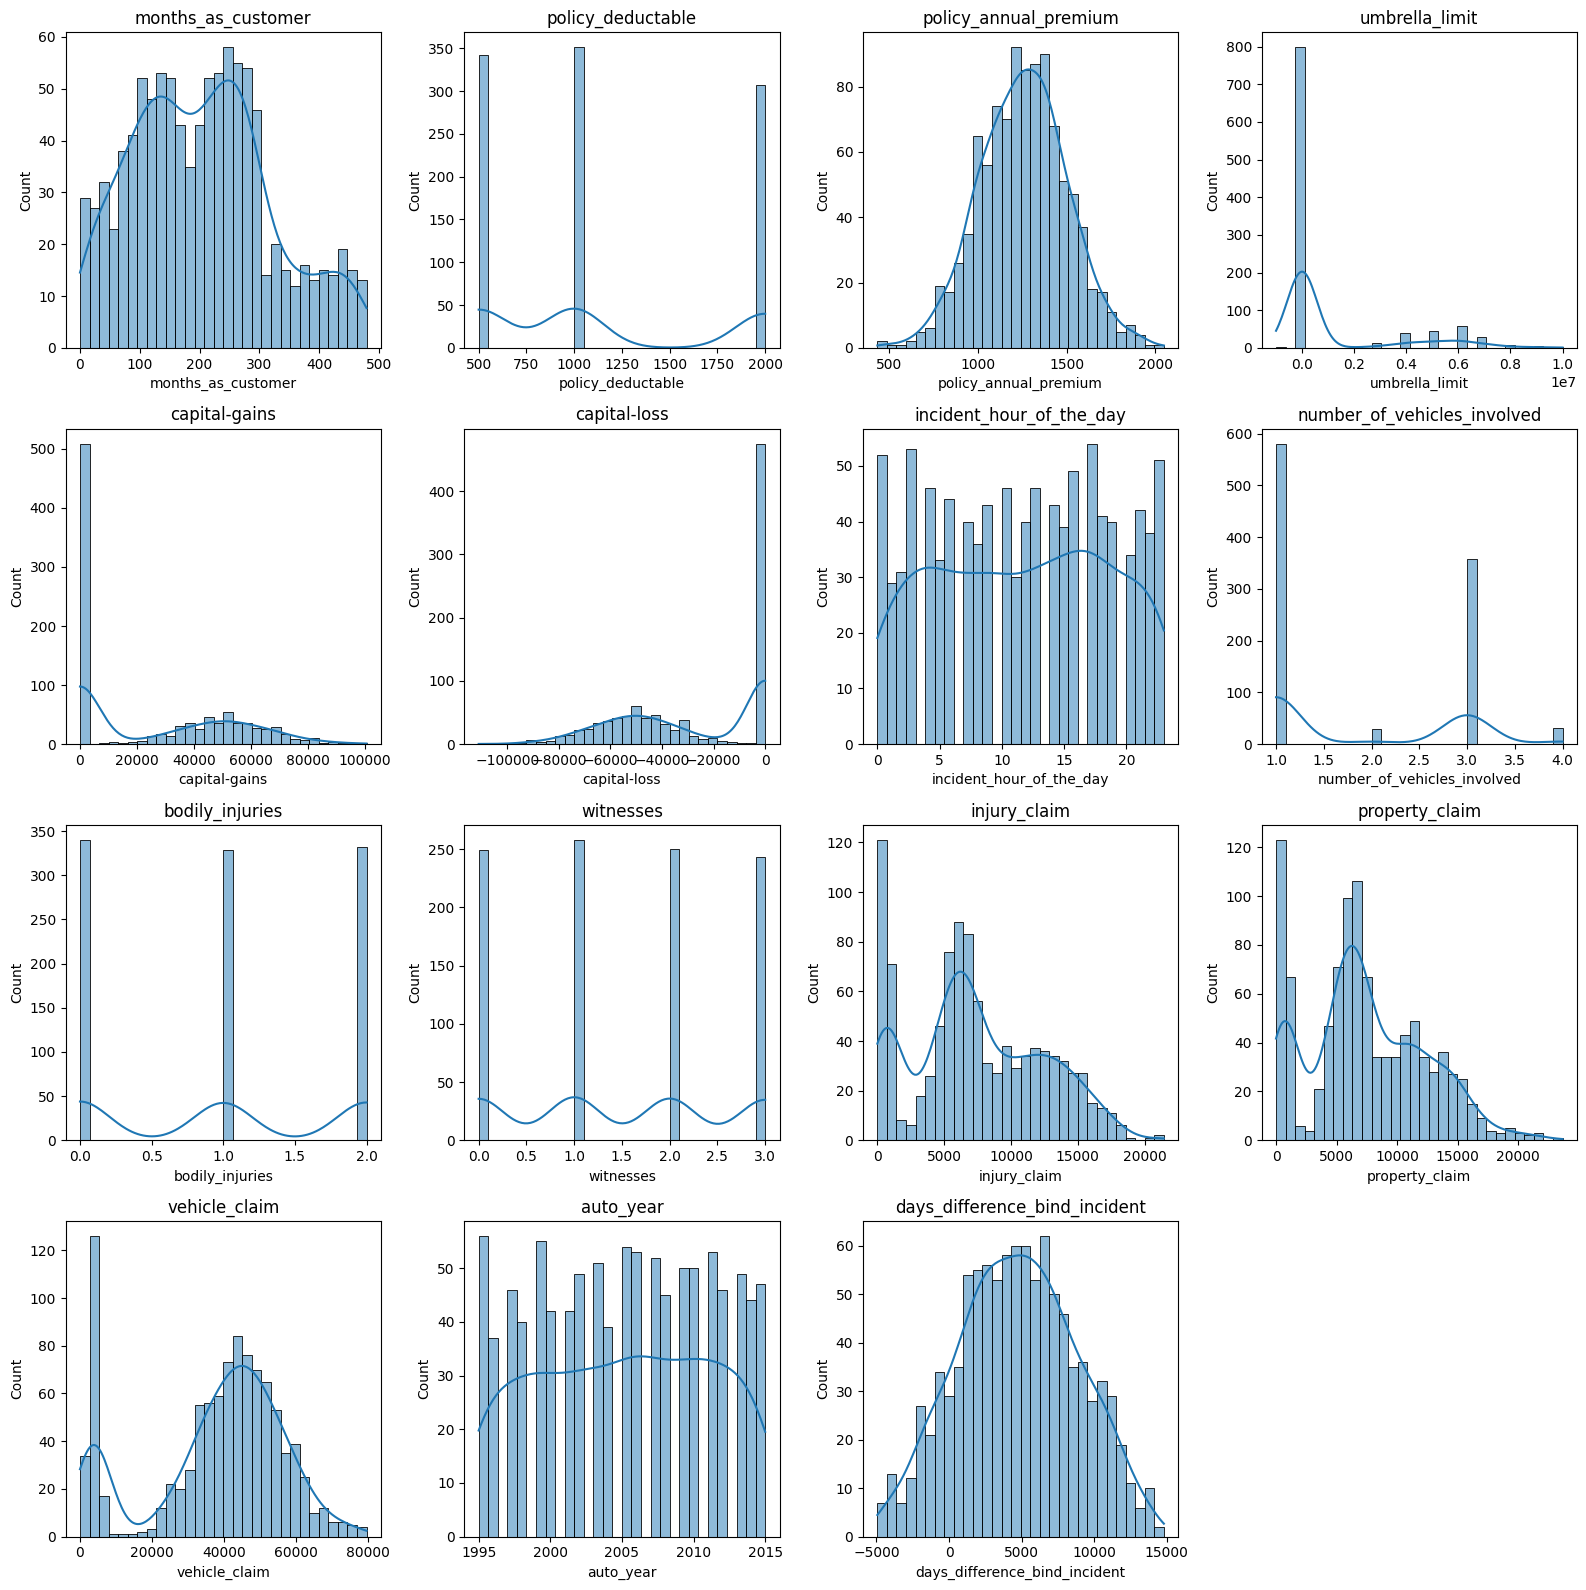

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = num.columns
print(num_cols)

plt.figure(figsize=(16, 16))  
for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i + 1) 
    sns.histplot(df[col], bins=30, kde=True)  # 'kde=True' adds a density estimate
    plt.title(col)
plt.tight_layout()  
plt.show()

C:\Users\D\AppData\Local\Temp\ipykernel_12088\2376226879.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportions.index, y=proportions.values, palette='viridis')
C:\Users\D\AppData\Local\Temp\ipykernel_12088\2376226879.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportions.index, y=proportions.values, palette='viridis')
C:\Users\D\AppData\Local\Temp\ipykernel_12088\2376226879.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportions.index, y=proportions.values, palette='viridis')
C:\Users\D\AppData\Local\Temp\i

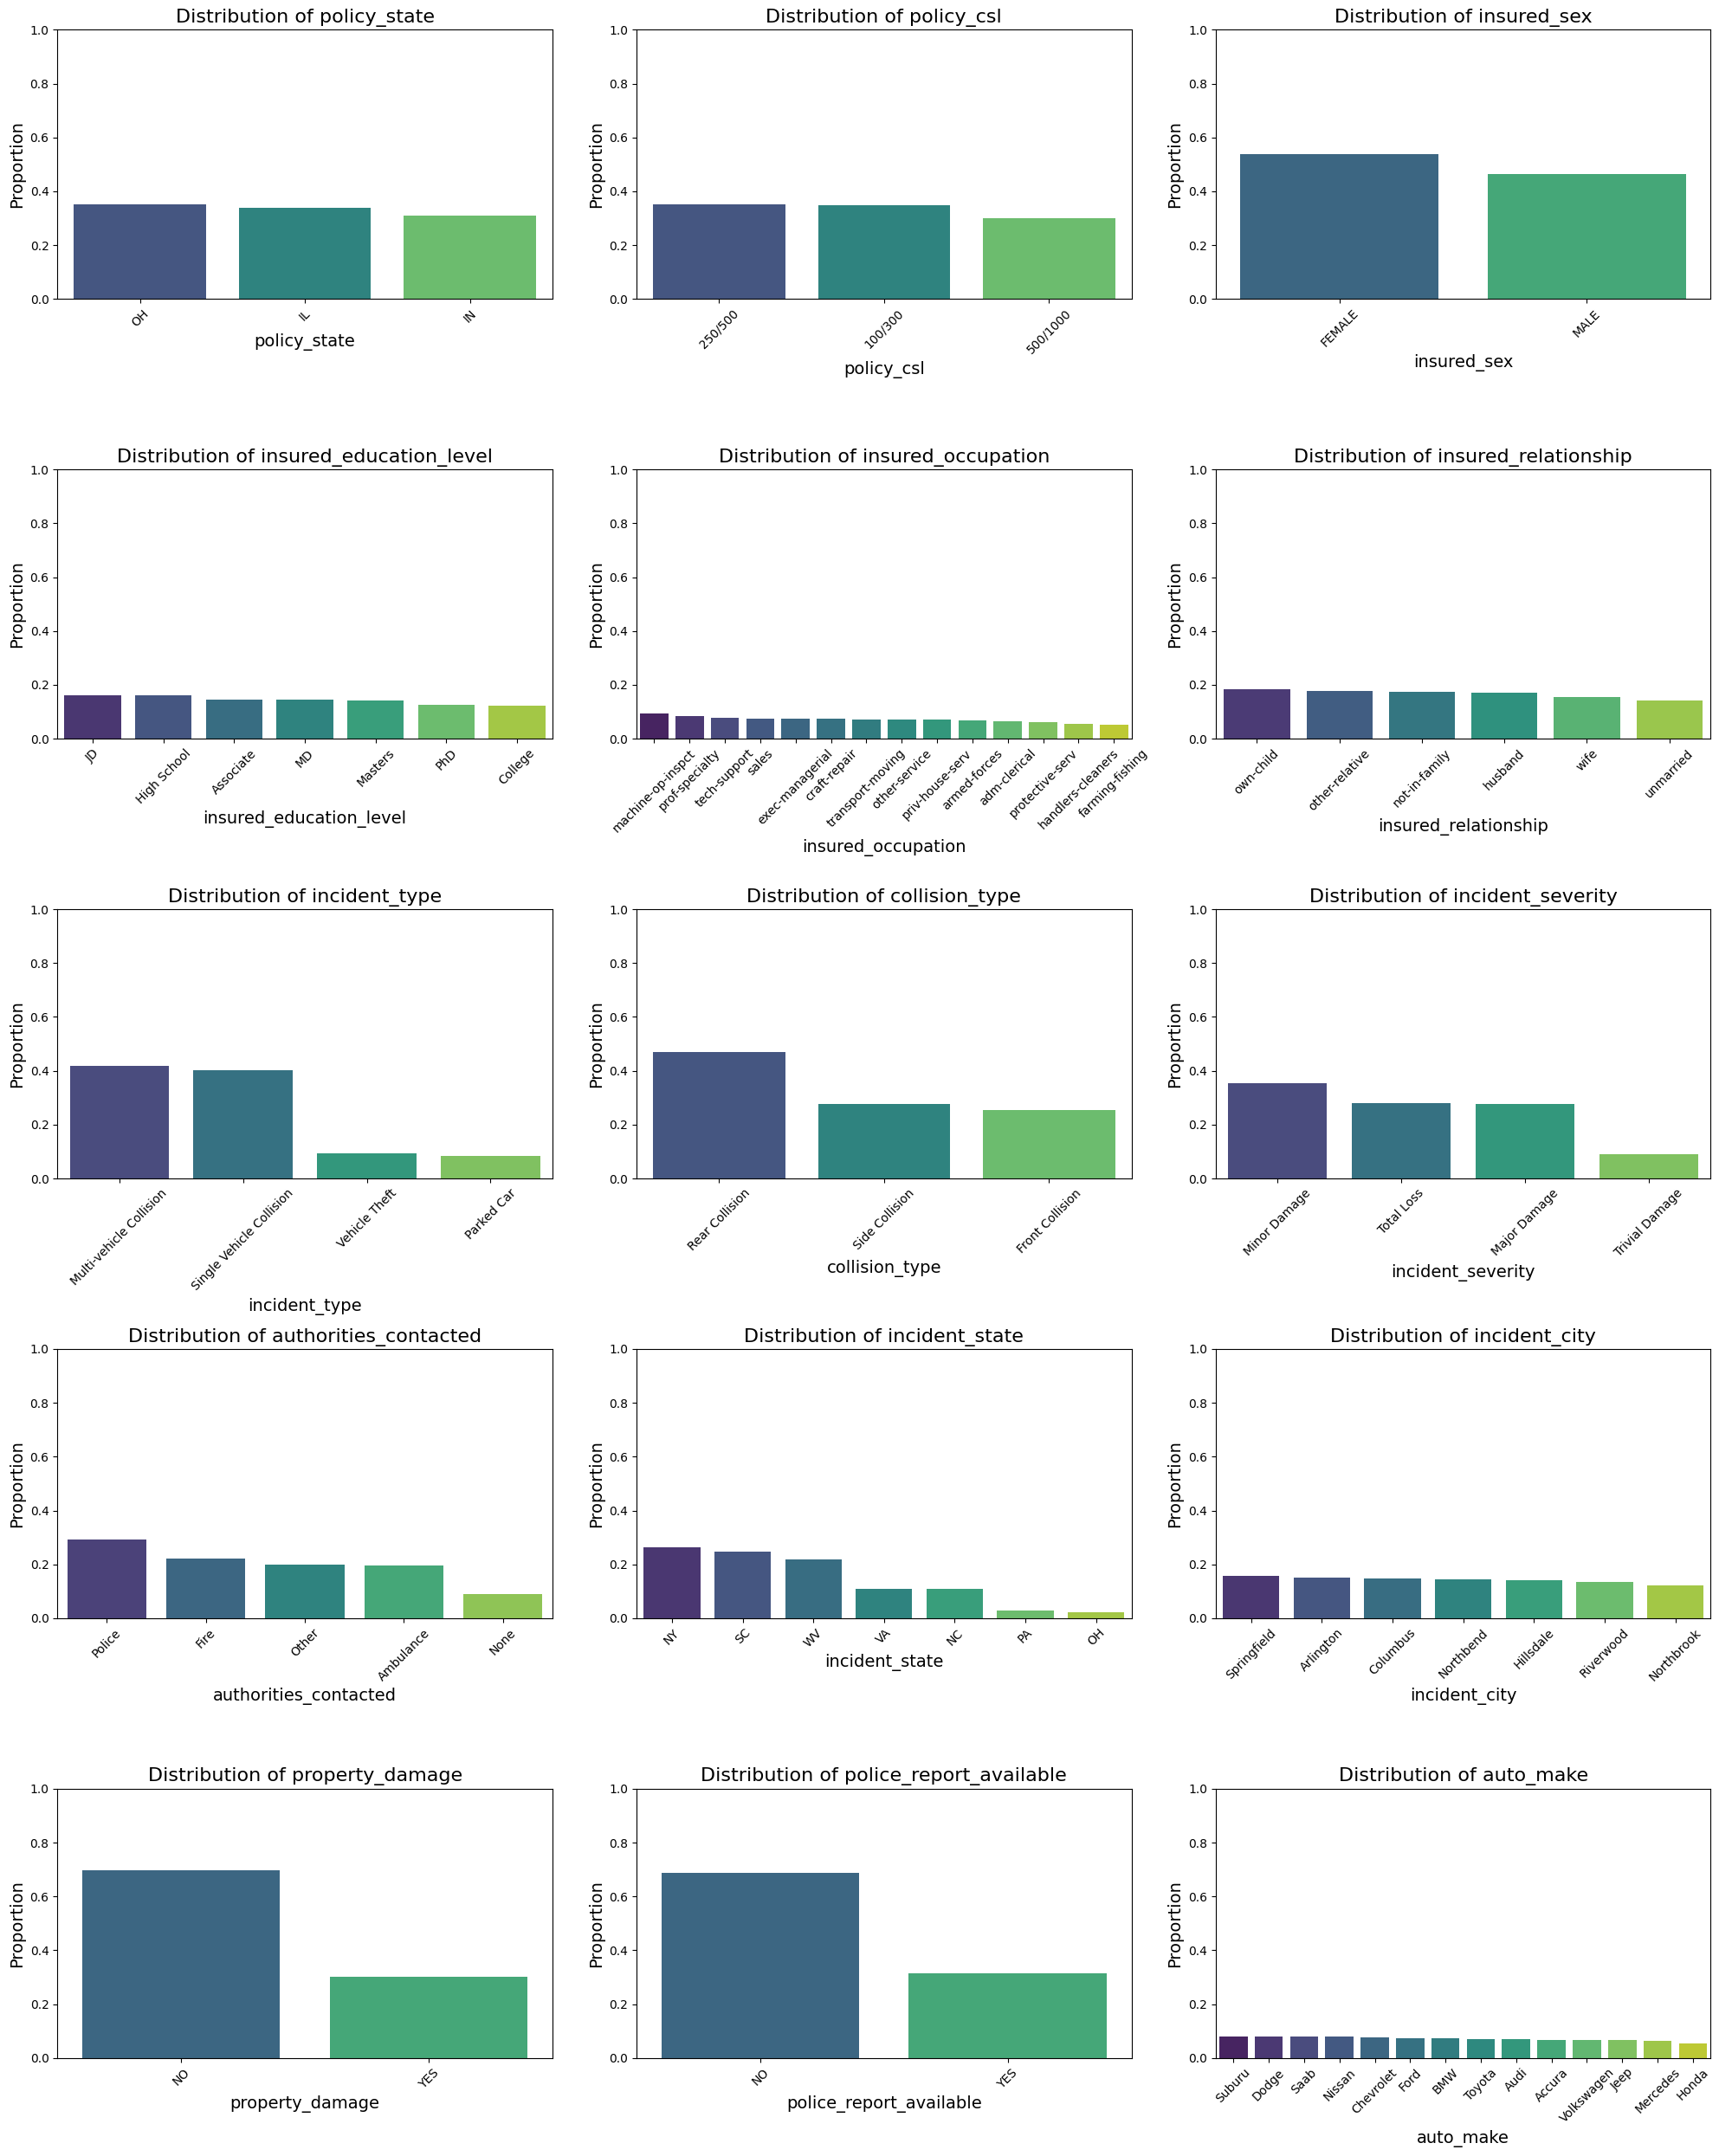

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample DataFrame for demonstration (replace with your own DataFrame)
# df = pd.read_csv('your_data.csv')  # Load your data
# cat_cols = df.select_dtypes(include='object').columns  # Get categorical columns

# Example categorical columns (replace with your actual categorical column names)
cat_cols = cat.columns
# Calculate the number of rows and columns needed
n_cols = 3  # Number of columns for subplots
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # Calculate number of rows needed

plt.figure(figsize=(20, n_rows * 5))  # Adjust height based on number of rows

# Plot proportions for each categorical variable
for i, col in enumerate(cat_cols):
    plt.subplot(n_rows, n_cols, i + 1)  # Adjust for dynamic row calculation
    proportions = df[col].value_counts(normalize=True)
    sns.barplot(x=proportions.index, y=proportions.values, palette='viridis')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Set y-axis limit for proportion

plt.tight_layout()
plt.show()


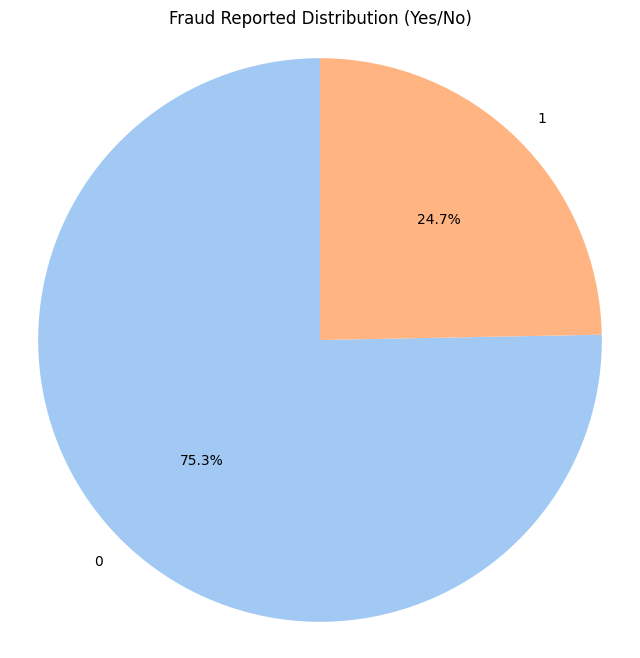

In [16]:
# checking the dependent variable

class_counts = y.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Fraud Reported Distribution (Yes/No)')
plt.axis('equal') 
plt.show()

# moderate level of class imbalance

In [17]:
cat = df.select_dtypes(include=['object']) 
cat = df.drop(columns='fraud_reported') 
cat_dummies = pd.get_dummies(cat, drop_first=False)
cat_dummies = cat_dummies.astype(int)  

X = pd.concat([num, cat_dummies], axis=1)

print(X.head())

   months_as_customer  policy_deductable  policy_annual_premium  \
0                 415               1000                 973.50   
1                  89               2000                1482.53   
2                 180                500                1272.46   
3                 160                500                1374.22   
4                 256                500                1203.17   

   umbrella_limit  capital-gains  capital-loss  incident_hour_of_the_day  \
0               0          50400             0                        15   
1               0          49100        -45100                         5   
2               0              0             0                         7   
3               0          45500        -37800                        19   
4               0          56700        -65600                        11   

   number_of_vehicles_involved  bodily_injuries  witnesses  ...  \
0                            2                1          3  ...   
1     

In [18]:
# splitting data into training set and test set (80/20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [19]:
# scaling num variables

scaler = StandardScaler()

num_df_train = X_train[num_cols]
scaled_data = scaler.fit_transform(num_df_train)
scaled_num_df_train = pd.DataFrame(data = scaled_data, columns = num_df_train.columns, index = X_train.index)
X_train.drop(columns = scaled_num_df_train.columns, inplace = True)
X_train = pd.concat([scaled_num_df_train, X_train], axis = 1)

num_df_test = X_test[num_cols]
scaled_data = scaler.fit_transform(num_df_test)
scaled_num_df_test = pd.DataFrame(data = scaled_data, columns = num_df_test.columns, index = X_test.index)
X_test.drop(columns = scaled_num_df_test.columns, inplace = True)
X_test = pd.concat([scaled_num_df_test, X_test], axis = 1)
X_test.head()


,months_as_customer,months_as_customer,policy_deductable,policy_deductable,policy_annual_premium,policy_annual_premium,umbrella_limit,umbrella_limit,capital-gains,capital-gains,...,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen
521,0.873537,0.873537,-0.223838,-0.223838,1.090439,1.089156,-0.471825,-0.471825,-0.928485,-0.928485,...,0,0,0,0,0,0,1,0,0,0
737,0.837338,0.837338,-0.223838,-0.223838,0.760998,0.762216,-0.471825,-0.471825,-0.928485,-0.928485,...,0,0,0,0,0,1,0,0,0,0
740,-1.651372,-1.651372,-0.223838,-0.223838,1.149010,1.147538,2.375397,2.375397,0.521664,0.521664,...,0,0,0,0,0,0,0,0,1,0
660,1.977620,1.977620,1.404076,1.404076,-0.575835,-0.576678,-0.471825,-0.471825,0.121011,0.121011,...,1,0,0,0,0,0,0,0,0,0
411,-1.108381,-1.108381,1.404076,1.404076,-0.042736,-0.043456,3.188889,3.188889,-0.928485,-0.928485,...,0,0,0,0,0,0,0,0,0,0


2. Model: trying to get the most accurate one 

In [20]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier()
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='Y') 
    recall = recall_score(y_test, y_pred, pos_label='Y')
    f1 = f1_score(y_test, y_pred, pos_label='Y')
    return accuracy, precision, recall, f1

results = {}
for model_name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

results_df = pd.DataFrame(results).transpose()
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)
print(results_df_sorted)

ValueError: pos_label=Y is not a valid label. It should be one of [0, 1]

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

models = {'LogisticRegression': LogisticRegression(max_iter=10000),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'SVC': SVC(),
          'GaussianNB':GaussianNB(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'RandomForestClassifier': RandomForestClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'XGBClassifier': XGBClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(0)
    model_scores = {}
    
    for name, model in models.items():
        model.fit(X_train,y_train)
        model_scores[name] = model.score(X_test,y_test)

    model_scores = pd.DataFrame(model_scores,index=['Score']).transpose()
    model_scores = model_scores.sort_values('Score')
    
    return model_scores

model_scores = fit_and_score(models,X_train,X_test,y_train,y_test)
cm = sns.color_palette('PuBuGn',as_cmap=True)
score = results_df_sorted.style.background_gradient(cmap=cm)
score

d:\test\outils\projets\pythonenvironment\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [232]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svc_train_acc = accuracy_score(y_train, svc.predict(X_train))
svc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Support Vector Classifier is : {svc_train_acc}")
print(f"Test accuracy of Support Vector Classifier is : {svc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Support Vector Classifier is : 0.755
Test accuracy of Support Vector Classifier is : 0.745
[[149   0]
 [ 51   0]]
              precision    recall  f1-score   support

           N       0.74      1.00      0.85       149
           Y       0.00      0.00      0.00        51

    accuracy                           0.74       200
   macro avg       0.37      0.50      0.43       200
weighted avg       0.56      0.74      0.64       200



d:\test\outils\projets\pythonenvironment\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\test\outils\projets\pythonenvironment\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\test\outils\projets\pythonenvironment\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r